In [1]:
import sys
from pathlib import Path
from addict import Dict

sys.path.append('../../')

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

from examples.utils.config import Config
from examples.utils.dataset_adapters import retina_dataset
from pyspikelib import TrainNormalizeTransform, TsfreshVectorizeTransform, TsfreshFeaturePreprocessorPipeline
from pyspikelib.utils import simple_undersampling
from pyspikelib.mpladeq import prettify, beautify_mpl, boxplot

beautify_mpl()

In [9]:
config_dict = {
    'seed': 0,
    'window': 200,
    'step': 200,
    'scale': True,
    'remove_low_variance': True,
    'train_subsample_factor': 0.7,
    'test_subsample_factor': 0.7,
    'delimiter': None,
    'feature_set': None,
    'dataset': '../../data/retina/mode_paper_data',
    'n_trees': 200,
    'fstate': 'randomly_moving_bar',
    'mstate': 'white_noise_checkerboard',
}

config = Config(config_dict)
np.random.seed(config.seed)

In [4]:
retinal_spike_data = retina_dataset(config.dataset)

In [10]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack(
    [
        retinal_spike_data[config.fstate].series.values,
        retinal_spike_data[config.mstate].series.values,
    ]
)
y = np.hstack(
    [
        np.ones(retinal_spike_data[config.fstate].shape[0]),
        np.zeros(retinal_spike_data[config.mstate].shape[0]),
    ]
)
groups = np.hstack(
    [
        retinal_spike_data[config.fstate].groups.values,
        retinal_spike_data[config.mstate].groups.values,
    ]
)

In [11]:
for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

In [12]:
normalizer = TrainNormalizeTransform(
    window=config.window, 
    step=config.step, 
    n_samples=None
)
X_train, y_train = normalizer.transform(X_train, y_train, delimiter=config.delimiter)
X_test, y_test = normalizer.transform(X_test, y_test, delimiter=config.delimiter)

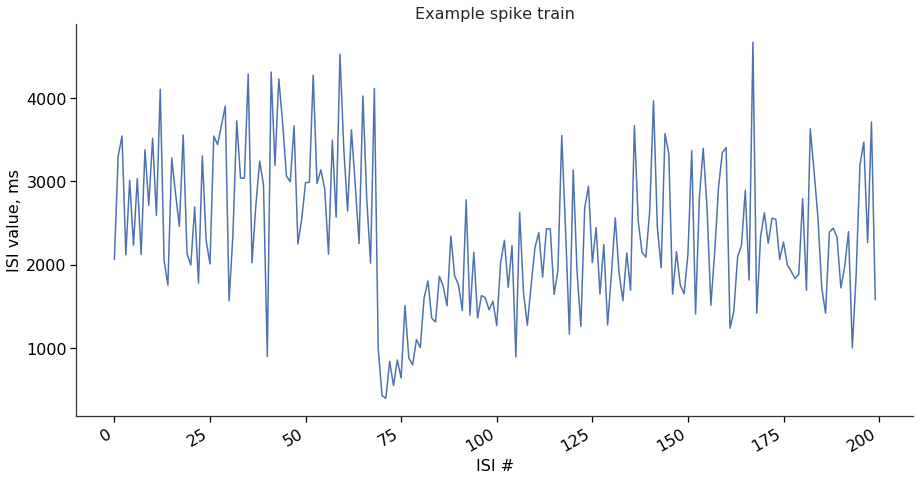

In [14]:
plt.plot(X_train[0, :])
plt.title('Example spike train')
plt.xlabel('ISI #')
plt.ylabel('ISI value, ms')
prettify((15, 8))

In [15]:
vectorizer = TsfreshVectorizeTransform(feature_set=config.feature_set)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

Feature Extraction: 100%|██████████| 119/119 [00:51<00:00,  2.33it/s]


In [16]:
preprocessing = TsfreshFeaturePreprocessorPipeline(
        do_scaling=config.scale, 
        remove_low_variance=config.remove_low_variance,
    ).construct_pipeline()
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

In [17]:
print('Dataset size: train {}, test {}'.format(X_train.shape, X_test.shape))
print('Average target: train {}, test {}'.format(y_train.mean(), y_test.mean()))

Dataset size: train (5736, 692), test (5920, 692)
Average target: train 0.7676080892608089, test 0.7782094594594594


In [18]:
feature_names = [
        'abs_energy',
        'mean',
        'median',
        'minimum',
        'maximum',
        'standard_deviation',
    ]
simple_baseline_features = ['value__' + name for name in feature_names]


def eval_classifier_scores(X_train, X_test, y_train, y_test, config):

    X_train, y_train = simple_undersampling(
        X_train, y_train, 
        subsample_size=config.train_subsample_factor
    )
    X_test, y_test = simple_undersampling(
        X_test, y_test, 
        subsample_size=config.test_subsample_factor
    )

    forest.fit(X_train, y_train)
    acc_score = accuracy_score(y_test, forest.predict(X_test))
    auc_roc_score = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])

    X_train = X_train.loc[:, simple_baseline_features]
    X_test = X_test.loc[:, simple_baseline_features]

    forest.fit(X_train, y_train)
    acc_score_simple_baseline = accuracy_score(y_test, forest.predict(X_test))
    auc_roc_score_simple_baseline = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])

    return acc_score, auc_roc_score, acc_score_simple_baseline, auc_roc_score_simple_baseline

In [19]:
num_trials = 10

classifier_scores = Dict()
classifier_scores.full_feature_set.acc = []
classifier_scores.full_feature_set.auc_roc = []
classifier_scores.simple_baseline.acc = []
classifier_scores.simple_baseline.auc_roc = []

forest = RandomForestClassifier(
    n_estimators=config.n_trees, 
    random_state=config.seed, 
    n_jobs=-1
)

for _ in range(num_trials):
    scores = eval_classifier_scores(X_train, X_test, y_train, y_test, config)

    acc, auc_roc, acc_simple_baseline, auc_roc_simple_baseline = scores
    
    classifier_scores.full_feature_set.acc.append(acc)
    classifier_scores.full_feature_set.auc_roc.append(auc_roc)
    classifier_scores.simple_baseline.acc.append(acc_simple_baseline)
    classifier_scores.simple_baseline.auc_roc.append(auc_roc_simple_baseline)

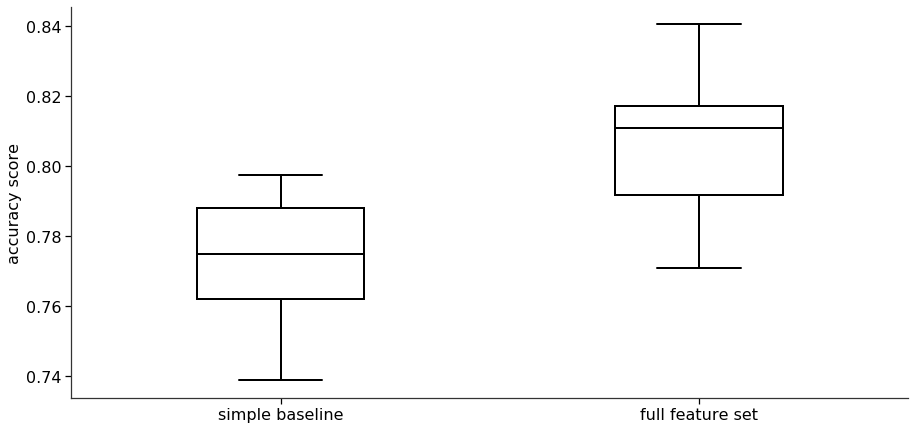

In [20]:
scores_df = pd.DataFrame({
    'accuracy score': classifier_scores.simple_baseline.acc + classifier_scores.full_feature_set.acc,
    'tag': ['simple baseline'] * len(classifier_scores.simple_baseline.acc) + \
        ['full feature set'] * len(classifier_scores.full_feature_set.acc)
})
    
boxplot(x='tag', y='accuracy score', data=scores_df, notch=False)